In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
# 이미지 로드하기

Xtrain = []

destination_path = os.path.expanduser('mydata/train/')

for imagename in os.listdir('mydata/train/'):
    Xtrain.append(img_to_array(load_img(destination_path+imagename, target_size=(256, 256))))
Xtrain = np.array(Xtrain, dtype=float)

# Normalize data
Xtrain = 1.0/255*Xtrain

In [3]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential

# model 만들기
def create_model():
    model = Sequential()

    #Input Layer
    model.add(Conv2D(64, (3, 3), 
                      input_shape=(256, 256, 1), 
                      activation='relu', 
                      padding='same'))
    #Hidden Layers
    model.add(Conv2D(64, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      strides=2))
    model.add(Conv2D(128, (3, 3), 
                      activation='relu', 
                      padding='same'))
    model.add(Conv2D(128, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      strides=2))
    model.add(Conv2D(256, (3, 3), 
                      activation='relu', 
                      padding='same'))
    model.add(Conv2D(256, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      strides=2))
    model.add(Conv2D(512, (3, 3), 
                       activation='relu', 
                       padding='same'))
    model.add(Conv2D(256, (3, 3), 
                      activation='relu', 
                      padding='same'))
    model.add(Conv2D(128, (3, 3), 
                      activation='relu', 
                      padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), 
                      activation='relu', 
                      padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), 
                      activation='relu', 
                      padding='same'))
    model.add(Conv2D(2, (3, 3), 
                      activation='tanh', 
                      padding='same'))
    model.add(UpSampling2D((2, 2)))

    #Compiling the CNN
    model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

    return model

In [4]:
model = create_model()

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 512)       1

In [5]:
from tensorflow.keras.callbacks import LearningRateScheduler

# 콜백함수 작성
callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))

tensorboard = TensorBoard(log_dir="./output/beta_run")

In [6]:
import matplotlib.pyplot as plt

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

trainedmodel = model.fit_generator(image_a_b_gen(batch_size), 
                                   callbacks=[tensorboard, LearningRateScheduler(scheduler, verbose=1), callbacks],
                                   epochs=150, 
                                   shuffle=True,
                                   steps_per_epoch=30)

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/150
30/30 [==============================] - 8s 274ms/step - loss: 0.2422 - accuracy: 0.6111 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/150
30/30 [==============================] - 8s 277ms/step - loss: 0.0101 - accuracy: 0.7037 - lr: 0.0010

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/150
30/30 [==============================] - 9s 287ms/step - loss: 0.0178 - accuracy: 0.7065 - lr: 0.0010

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/150
30/30 [==============================] - 8s 278ms/step - loss: 0.0228 - accuracy: 0.7025 - lr: 0.0010

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/150
30/30 [==============================] - 8s 279ms/step - loss: 0.0195 - accuracy: 0.7031 - lr: 0.0010

Epoch 00

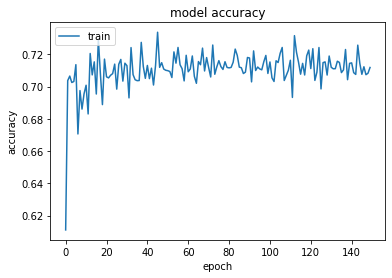

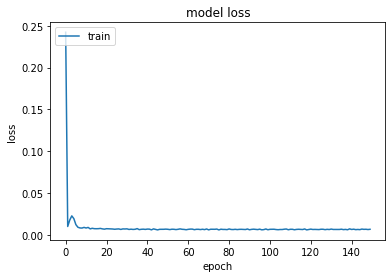

In [7]:
# summarize history for accuracy
plt.plot(trainedmodel.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
# Save model

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [2]:
# load json and create model

from tensorflow.keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

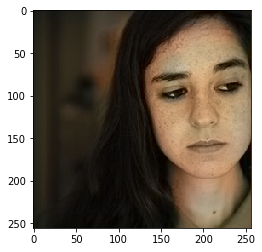

In [3]:
from pylab import *

img1_color = []

img1 = img_to_array(load_img('mydata/test/01.jpg'))
img1_color.append(img1)

img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255 * img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = loaded_model.predict(img1_color)
output1 = output1 * 128

result = np.zeros((256,256,3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
imshow(lab2rgb(result))